# MNIST_with_CNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

## 加载数据

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot= True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


#### 关于数据集

MNIST数据集中包含了三个部分：55000个训练集（mnist.train），10000个测试集（mnist.test）和5000个验证集（mnist.validation）

#### 绘制前10个训练集图像

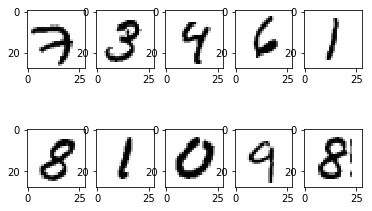

[7 3 4 6 1 8 1 0 9 8]


In [50]:
for i in range(10):
    image = mnist.train.images[i]
    plt.subplot(2,5,i+1)
    plt.imshow(image.reshape([28,28]), cmap='gray_r')
plt.show()
print(np.argmax(mnist.train.labels[:10], 1))

In [51]:
val_features = np.array([ mnist.validation.images[i].reshape((28,28,1))  for i in range(mnist.validation.images.shape[0])])
print(val_features.shape)
val_labels = mnist.validation.labels
print(val_labels.shape)

(5000, 28, 28, 1)
(5000, 10)


## 构建卷积神经网络

使用3个卷积层+池化层，2个全连接层构建神经网络

### 权重初始化

In [52]:
def init_weight(shape):
    init = tf.truncated_normal(shape, mean=0,  stddev=0.1)
    return tf.Variable(init)

# 偏置初始化
def init_bias(shape):
    init = tf.zeros(shape = shape)
    return tf.Variable(init)

**注：**这里需要注意权重初始化时的stddev，权重在初始化的时候越靠近0越好，因为当权重全部为0的时候，意味着所有的反向传播值都是一样的，也就是说神经网络没有从误差中学到任何东西，也就无法体现这些超参数的差异化；如果初始化的值远离0了，那么可能会使神经网络在初始化的时候出面对某种结果的喜好，从而影响网络的训练，这种情况可能会使网络陷入局部解。

### 构建各个层

#### 卷积层和池化层

In [53]:
# 卷积层
def conv2d(x_tensor, outputs_num, kernel_size=(3,3), strides=(1,1,1,1) ):
    shape = x_tensor.get_shape().as_list()
    weight = init_weight([kernel_size[0], kernel_size[1], shape[3], outputs_num])
    bias = init_bias([outputs_num])
    
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides, padding='SAME' )
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    conv_layer = tf.nn.relu(conv_layer)
    return conv_layer

# 池化层
def pooling(x_tensor, kernel_size=(2,2), strides=(1,2,2,1)):
    pooling_layer = tf.nn.max_pool(x_tensor, ksize=[1, kernel_size[0],kernel_size[1],1], strides=strides, padding="SAME")
    return pooling_layer

#### 扁化层
扁化层是用来把最后一个卷积池化层的输出转换成单一向量，用来作为后面全连接层的输入层

In [54]:
def flatten(x_tensor):
    shape = x_tensor.get_shape().as_list()
    x_tensor = tf.reshape(x_tensor, [-1, shape[1]*shape[2]*shape[3]])
    return x_tensor

#### 全连接层

In [55]:
def fully_conn(x_tensor, num_outputs, activation=tf.nn.relu):
    return tf.layers.dense(x_tensor, num_outputs, activation=activation)

### 构建全局神经网络

In [56]:
def conv_net(x, keep_probility):
    
    conv_layer1 = conv2d(x, 64)
    pooling_layer1 = pooling(conv_layer1)
    
    conv_layer2 = conv2d(pooling_layer1, 128)
    pooling_layer2 = pooling(conv_layer2)

    conv_layer3 = conv2d(pooling_layer2, 256)
    pooling_layer2 = pooling(conv_layer3)
    
    flatten_layer = flatten(conv_layer3)
    
    fully_conn_layer1 = fully_conn(flatten_layer, 256)
    fully_conn_layer1 = tf.nn.dropout(fully_conn_layer1, keep_prob = keep_probility)
    fully_conn_layer2 = fully_conn(fully_conn_layer1, 128)
    fully_conn_layer2 = tf.nn.dropout(fully_conn_layer2, keep_prob = keep_probility)
    
    output = fully_conn(fully_conn_layer2, 10, activation=None)
    return output

In [57]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name="x")
y = tf.placeholder(tf.float32, shape=[None, 10], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

logits = conv_net(x, keep_prob)
logits = tf.identity(logits, name='logits')
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)


correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32),name='accuracy')

In [58]:
def train_nn(session, optimizer, feature_batch, label_batch, keep_probility):
    session.run(optimizer, feed_dict={x: feature_batch, y: label_batch, keep_prob: keep_probility})

def print_status(session, feature_batch, label_batch, cost, accuracy):
    loss = session.run(cost, feed_dict={ x: feature_batch, y: label_batch , keep_prob: 1 })
    
    acc = []
    batch_size=4096
    batches = mnist.validation.images.shape[0] // batch_size +1
    for i in range(1, batches+1):
        val_batch = mnist.validation.next_batch(batch_size)
        val_features_batch = val_batch[0].reshape( [-1, 28,28,1])
        val_labels_batch = val_batch[1]
        acc.append( session.run(accuracy, feed_dict={x : val_features_batch, y: val_labels_batch, keep_prob:1}))
    acc = np.mean(acc)
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,acc))
    

In [59]:
epochs = 10
batch_size=4096
keep_probility = 0.75

In [60]:
save_model_path = './model'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        batches = mnist.train.images.shape[0] // batch_size +1

        for i in range(1, batches+1):
            batch = mnist.train.next_batch(batch_size)
            train_features_batch = batch[0].reshape( [-1, 28,28,1])
            train_labels_batch = batch[1]
            train_nn(sess, optimizer, feature_batch = train_features_batch, label_batch = train_labels_batch, keep_probility=keep_probility)
            print('Epoch {:>2}, MNIST Batch {}:  '.format(epoch + 1, i), end='')
            print_status(sess, train_features_batch,train_labels_batch, cost, accuracy )
            
#   在测试集上进行测试       
    acc = []
    test_batch_size = 4096
    test_batches_num = (mnist.test.images.shape[0] // test_batch_size) +1
    for i in range(1, test_batches_num+1):
        batch = mnist.test.next_batch(test_batch_size)
        test_features_batch = batch[0].reshape( [-1, 28,28,1])
        test_labels_batch = batch[1]
        
        acc.append(sess.run(accuracy, feed_dict={x: test_features_batch, y: test_labels_batch, keep_prob:1} ))
    acc = np.mean(acc)
    print('MNIST accuracy on test set: {} '.format(acc), end='')
    
    # 保存模型
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    print(save_path)

Epoch  1, MNIST Batch 1:  Loss:     2.0209 Validation Accuracy: 0.303345
Epoch  1, MNIST Batch 2:  Loss:     1.7948 Validation Accuracy: 0.481445
Epoch  1, MNIST Batch 3:  Loss:     1.4333 Validation Accuracy: 0.657593
Epoch  1, MNIST Batch 4:  Loss:     1.1217 Validation Accuracy: 0.717285
Epoch  1, MNIST Batch 5:  Loss:     0.9481 Validation Accuracy: 0.689819
Epoch  1, MNIST Batch 6:  Loss:     0.7462 Validation Accuracy: 0.792725
Epoch  1, MNIST Batch 7:  Loss:     0.6289 Validation Accuracy: 0.831909
Epoch  1, MNIST Batch 8:  Loss:     0.4952 Validation Accuracy: 0.872559
Epoch  1, MNIST Batch 9:  Loss:     0.4357 Validation Accuracy: 0.880127
Epoch  1, MNIST Batch 10:  Loss:     0.3577 Validation Accuracy: 0.894653
Epoch  1, MNIST Batch 11:  Loss:     0.3578 Validation Accuracy: 0.902466
Epoch  1, MNIST Batch 12:  Loss:     0.3127 Validation Accuracy: 0.912964
Epoch  1, MNIST Batch 13:  Loss:     0.2752 Validation Accuracy: 0.921143
Epoch  1, MNIST Batch 14:  Loss:     0.2711 Val

Epoch  9, MNIST Batch 1:  Loss:     0.0170 Validation Accuracy: 0.989868
Epoch  9, MNIST Batch 2:  Loss:     0.0161 Validation Accuracy: 0.990723
Epoch  9, MNIST Batch 3:  Loss:     0.0215 Validation Accuracy: 0.991699
Epoch  9, MNIST Batch 4:  Loss:     0.0255 Validation Accuracy: 0.989990
Epoch  9, MNIST Batch 5:  Loss:     0.0164 Validation Accuracy: 0.990356
Epoch  9, MNIST Batch 6:  Loss:     0.0210 Validation Accuracy: 0.990723
Epoch  9, MNIST Batch 7:  Loss:     0.0203 Validation Accuracy: 0.990356
Epoch  9, MNIST Batch 8:  Loss:     0.0161 Validation Accuracy: 0.990479
Epoch  9, MNIST Batch 9:  Loss:     0.0169 Validation Accuracy: 0.990967
Epoch  9, MNIST Batch 10:  Loss:     0.0152 Validation Accuracy: 0.991089
Epoch  9, MNIST Batch 11:  Loss:     0.0136 Validation Accuracy: 0.991943
Epoch  9, MNIST Batch 12:  Loss:     0.0163 Validation Accuracy: 0.991577
Epoch  9, MNIST Batch 13:  Loss:     0.0144 Validation Accuracy: 0.992188
Epoch  9, MNIST Batch 14:  Loss:     0.0133 Val

#### 在测试集上测试模型

In [8]:
save_model_path = './model'
loaded_graph = tf.Graph()
with tf.Session(graph = loaded_graph) as sess:
    loader = tf.train.import_meta_graph(save_model_path+ '.meta')
    loader.restore(sess, save_model_path)
    
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    
    acc = []
    batch_size = 256
    batches = (mnist.test.images.shape[0] // batch_size) +1
    for i in range(1, batches+1):
        batch = mnist.test.next_batch(batch_size)
        test_features_batch = batch[0].reshape( [-1, 28,28,1])
        test_labels_batch = batch[1]
        
        acc.append(sess.run(loaded_acc, feed_dict={loaded_x: test_features_batch, loaded_y: test_labels_batch, loaded_keep_prob:1} )) #, 
    acc = np.mean(acc)
    print('MNIST accuracy on test set: {} '.format(acc), end='')

NameError: name 'keep_prob' is not defined